# Домашнее задание 3. Алгоритмы кластеризации

Основная задача этого задания -- реализация одного из алгоритмов кластеризации. Кроме того, мы научимся подбирать параметры алгоритма, визуализируем результат кластеризации и попытаемся проанализировать природу полученных кластеров.

In [23]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt
import heapq as hp
from tqdm import tqdm

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Cчитываем данные, полученные в результате выполнения предыдущего домашнего задания, в `data frame` библиотеки `pandas`. Конвертируем данные в массив `numpy`.

In [2]:
data_df = pd.read_csv("hw2_out.csv", sep="\t", header=0, index_col="uid")
x = data_df.values

Алгоритм кластеризации, который необходимо реализовать, выбирается на основании Вашего логина на портале Техносферы. При проверке домашнего задания бадут осуществляться проверка логина и соответствующего алгоритма.

In [3]:
algorithms = [
    u"Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - k)",
    u"Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)",
    u"DBSCAN. (параметры  - epsilon, min_pts)", 
    u"OPTICS. (параметры - epsilon, min_pts)"
]

my_algorithm = algorithms[hash("b.yakimov") % len(algorithms)]
print u"Реализуем алгоритм кластеризации '%s'" % my_algorithm

Реализуем алгоритм кластеризации 'Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)'


Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`

In [4]:
from pprint import pprint
import random as rand

In [5]:
class priority_dict(dict):
    """Dictionary that can be used as a priority queue.

    Keys of the dictionary are items to be put into the queue, and values
    are their respective priorities. All dictionary methods work as expected.
    The advantage over a standard heapq-based priority queue is
    that priorities of items can be efficiently updated (amortized O(1))
    using code as 'thedict[item] = new_priority.'

    The 'smallest' method can be used to return the object with lowest
    priority, and 'pop_smallest' also removes it.

    The 'sorted_iter' method provides a destructive sorted iterator.
    """
    
    def __init__(self, *args, **kwargs):
        super(priority_dict, self).__init__(*args, **kwargs)
        self._rebuild_heap()

    def _rebuild_heap(self):
        self._heap = [(v, k) for k, v in self.iteritems()]
        hp.heapify(self._heap)

    def smallest(self):
        """Return the item with the lowest priority.

        Raises IndexError if the object is empty.
        """
        
        heap = self._heap
        v, k = heap[0]
        while k not in self or self[k] != v:
            hp.heappop(heap)
            v, k = heap[0]
        return k

    def pop_smallest(self):
        """Return the item with the lowest priority and remove it.

        Raises IndexError if the object is empty.
        """
        
        heap = self._heap
        v, k = hp.heappop(heap)
        while k not in self or self[k] != v:
            v, k = hp.heappop(heap)
        del self[k]
        return k

    def __setitem__(self, key, val):
        # We are not going to remove the previous value from the heap,
        # since this would have a cost O(n).
        
        super(priority_dict, self).__setitem__(key, val)
        
        if len(self._heap) < 2 * len(self):
            hp.heappush(self._heap, (val, key))
        else:
            # When the heap grows larger than 2 * len(self), we rebuild it
            # from scratch to avoid wasting too much memory.
            self._rebuild_heap()

    def setdefault(self, key, val):
        if key not in self:
            self[key] = val
            return val
        return self[key]

    def update(self, *args, **kwargs):
        # Reimplementing dict.update is tricky -- see e.g.
        # http://mail.python.org/pipermail/python-ideas/2007-May/000744.html
        # We just rebuild the heap from scratch after passing to super.
        
        super(priority_dict, self).update(*args, **kwargs)
        self._rebuild_heap()

    def sorted_iter(self):
        """Sorted iterator of the priority dictionary items.

        Beware: this will destroy elements as they are returned.
        """
        
        while self:
            yield self.pop_smallest()

In [7]:
from datetime import datetime

In [26]:
class Clustering:
    """
    Implement clustering algorithm according 
    """ 
    def object_dist(self,a,b, p = 2):
        """
        return Lp-distance between object a and object b, Euclidean distance setted as default
        """
        return np.power(np.power(a-b,p).sum(),1./p)
    
    def distance(self,a,b,x):
        """
        return distance between cluster x and cluster aUb that are being merged
        """
    
        if(self.linkage == 'single'):
            return min(self.d[a,x],self.d[b,x])
        
        if(self.linkage == 'complete'):
            return max(self.d[a,x],self.d[b,x])
        
        if(self.linkage == 'average'):
            return (self.size[a]*d[a,x]+self.size[b]*d[b,x])/(float(self.size[a]+self.size[b]))
        
        
        #print "merged result",min(closest_1,closest_2)
        
    def get_delta_set(self,K1 = 20, K2 = 20): 
        
        heap = priority_dict()
        self.delta = np.inf
        if self.C <= K1:
            for i in self.cluster_set:
                for j in self.cluster_set:
                    if j>i:
                        heap[i,j] = self.d[i,j]

            return heap
        
        else:
            n = int(np.round(np.sqrt(K2))) + 1
            random_clusters = np.array(list(self.cluster_set))
            random_clusters = np.random.choice(random_clusters,n,replace = False)
            for i in random_clusters[:n]: 
                for j in random_clusters[-n:]:
                    if j>i:
                        if self.d[i,j] < self.delta:
                            self.delta = self.d[i,j]
                            
            for i in self.cluster_set:
                for j in self.cluster_set:
                    if j>i:
                        if self.d[i,j] <= self.delta:
                            heap[i,j] = self.d[i,j]

            return heap    
        
    def rename_clusters(self):
        x = self.labels
        renamed = {old:new for new,old in enumerate(np.unique(x))}
        return np.array([renamed[i] for i in x])
    
    def __init__(self, k = 2,linkage = 'single'):
        """
        Please add necessary algoritm parameters to class constructor
        """
        self.k = k
        self.linkage = linkage
        return None
        
    def fit(self, x, y=None):
        """
        Use data matrix x to compute model parameters
        """
        self.N = x.shape[0] #initialize number of objects
        self.C = self.N #initialize number of clusters
        self.labels = np.array([i for i in xrange(self.C)]) #set initial clusters
        self.d = np.zeros((self.N,self.N)) #pairwise dissimilarities
        self.cluster_set = set(i for i in xrange(self.N))
        for i in tqdm(xrange(self.N)): #filling dissimilarity matrix
            for j in xrange(self.N):
                self.d[i,j] = self.object_dist(x[i,:],x[j,:])
        
         #filling initial nearest neighbours, mindist and size of clusters#realize argmin d[x,y] for y > x
        self.size = [1 for x in xrange(self.N)] # <- size of each cluster
        self.heap = priority_dict()
        self.heap = self.get_delta_set()
        return self
    
    def predict(self, x):
        """
        Using computed model parameters predict cluster
        for all objects from x
        """
        
        for self.C in tqdm(xrange(self.N, self.k, -1)):
            
            a,b = self.heap.smallest() 
            self.heap.pop_smallest() 
            self.labels[self.labels == b] = a #merge
            
            self.size[a] = self.size[a] + self.size[b] #reuse a as new index cluster
            self.cluster_set.remove(b)

            for x in self.cluster_set: #updating distance matrix
                clust_dist = self.distance(a,b,x)
                self.d[x,a] = clust_dist
                self.d[a,x] = clust_dist
            remove = set()
        
            for  x in self.cluster_set:
                if self.d[a,x] > self.delta:
                    remove.add((b,x))
                    remove.add((x,b))
                    remove.add((x,a))
                    remove.add((a,x))
                else:
                    if x > a:
                        self.heap[a,x] = self.d[a,x]
                        remove.add((b,x))
                        remove.add((x,b))
                        remove.add((x,a))
                    elif x < a:
                        self.heap[x,a] = self.d[a,x]
                        remove.add((b,x))
                        remove.add((x,b))
                        remove.add((a,x))
            
            for pair in remove:
                if pair in self.heap:
                    del self.heap[pair]
        
            if len(self.heap) < 1: #get delta set excplicitly to save tume
                self.delta = 100
                K1 = 20
                K2 = 20
                if self.C <= K1:
                    for i in self.cluster_set:
                        for j in self.cluster_set:
                            if j>i:
                                self.heap[i,j] = self.d[i,j]

                else:
                    n = int(np.round(np.sqrt(K2))) + 1
                    random_clusters = np.array(list(self.cluster_set))
                    random_clusters = np.random.choice(random_clusters,n,replace = False)
                    for i in random_clusters[:n]: 
                        for j in random_clusters[-n:]:
                            if j>i:
                                if self.d[i,j] < self.delta:
                                    self.delta = self.d[i,j]

                    for i in self.cluster_set:
                        for j in self.cluster_set:
                            if j>i:
                                if self.d[i,j] <= self.delta:
                                    self.heap[i,j] = self.d[i,j]

                    
        self.labels = self.rename_clusters() 
        return self.labels
    
    def fit_predict(self, x, y=None):
        self.fit(x, y)
        return self.predict(x)

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

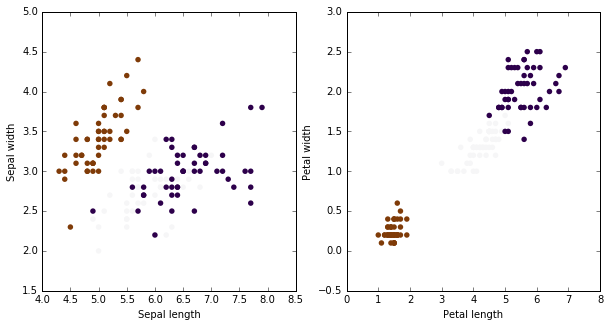

In [9]:
iris = ds.load_iris()
x_iris = iris.data
y_iris = iris.target

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

In [27]:
#%timeit 
pred_iris = Clustering(k = 2).fit_predict(x_iris[:100])

print "Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris[:100], pred_iris)

100%|██████████| 98/98 [00:00<00:00, 6220.65it/s]

Adjusted Rand index for iris is: 1.00


Выбрать и реализовать критерий качества, на основании которого будут подбираться параметры модели. Варианты критериев:
- Инерция (сумма квадратов расстояний от каждой из точек до ближайшего к этой точке центроида)
- Средний диаметр (максимальное расстояние между точками в кластере) или радиус (расстояние от центроида до самой дальней от него точки в кластере)
- Sihouette

**Критерий качества необходимо выбрать таким образом, чтобы он подходил для реализованного алгоритма**

In [11]:
def quality(x, y, criterion = 'inertion'):
    """
    Implement quality criterion of your choice
    """
    J = 0
    if criterion == 'inertion':
        for cls in np.unique(y):
            J += ((x[y == cls] - x[y == cls].mean(axis = 0))**2).sum() #inertion calculation
        return J
    elif criterion == 'radius':
        for cls in np.unique(y):
            J += np.sqrt(((x[y == cls] - x[y == cls].mean(axis = 0))**2).sum(axis = 1)).max()
        J = J/len(np.unique(y))
        return J

        
    

Применим критерий для выбора параметров алгоритма. Предлагается изменить следующий код таким образом, чтобы кластеризация вызывалась с верным набором параметров. На графике можно будет увидеть зависимость критерия от параметров алгоритма. Необходимо выбрать оптимальные значения этих параметров.

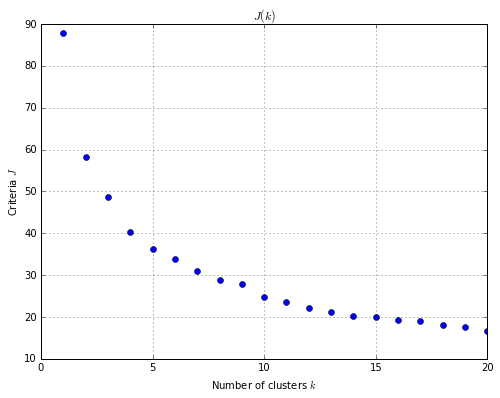

In [12]:
#competing sklearn Agglomerative clustering and Clustering()
from datetime import datetime
from sklearn.cluster import AgglomerativeClustering as AC

ks = range(1, 21)
criteria = np.zeros(len(ks))

for i, k in enumerate(ks):
    cls_AC = AC(n_clusters = k, linkage= 'complete')
    y_control = cls_AC.fit_predict(x[:400,:])
    criteria[i] = quality(x[:400,:], y_control,'inertion')
    
pl.figure(figsize=(8, 6))
pl.plot(ks, criteria,'o')
pl.title("$J(k)$")
pl.ylabel("Criteria $J$")
pl.xlabel("Number of clusters $k$")
pl.grid()
pl.show()

In [13]:
ks = range(1, 21)
criteria = np.zeros(len(ks))

for i, k in enumerate(ks):
    cls = Clustering(k = k,linkage = 'complete')
    y = cls.fit_predict(x[:400,:])
    criteria[i] = quality(x[:400,:], y)
    cls_AC = AC(n_clusters = k, linkage= 'complete')
    y_control = cls_AC.fit_predict(x[:400,:])
    print "adjusted rand score between my cluster and AC from sklearn",smt.adjusted_rand_score(y_control, y)
    
    

adjusted rand score between my cluster and AC from sklearn 1.0
adjusted rand score between my cluster and AC from sklearn 1.0
adjusted rand score between my cluster and AC from sklearn 1.0
adjusted rand score between my cluster and AC from sklearn 1.0
adjusted rand score between my cluster and AC from sklearn 1.0
adjusted rand score between my cluster and AC from sklearn 1.0
adjusted rand score between my cluster and AC from sklearn 1.0
adjusted rand score between my cluster and AC from sklearn 1.0
adjusted rand score between my cluster and AC from sklearn 1.0
adjusted rand score between my cluster and AC from sklearn 1.0
adjusted rand score between my cluster and AC from sklearn 1.0
adjusted rand score between my cluster and AC from sklearn 1.0
adjusted rand score between my cluster and AC from sklearn 1.0
adjusted rand score between my cluster and AC from sklearn 1.0
adjusted rand score between my cluster and AC from sklearn 1.0
adjusted rand score between my cluster and AC from skle

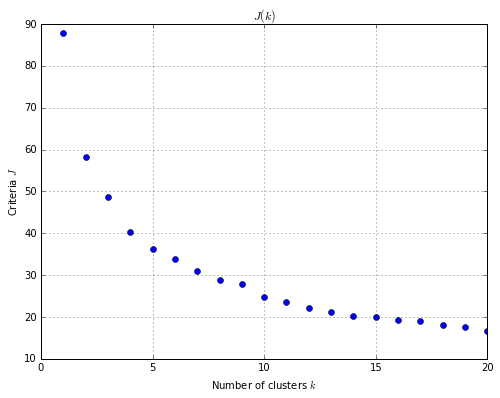

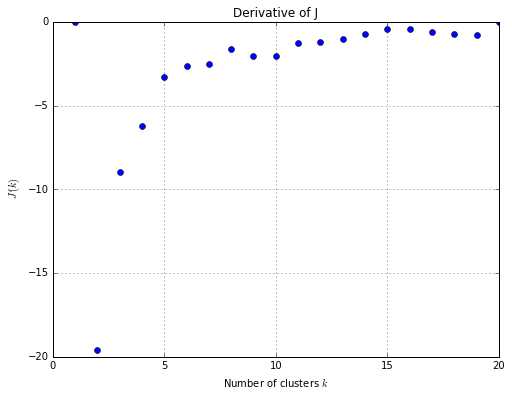

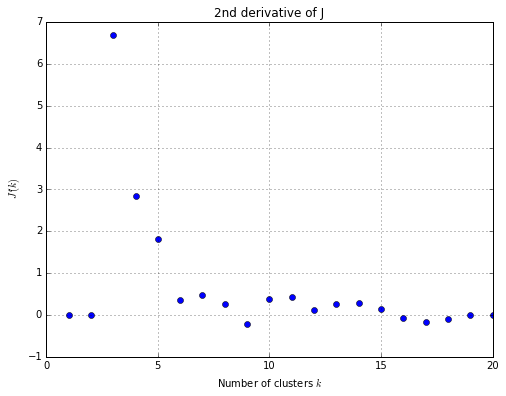

In [14]:
pl.figure(figsize=(8, 6))
pl.plot(ks, criteria,'o')
pl.title("$J(k)$")
pl.ylabel("Criteria $J$")
pl.xlabel("Number of clusters $k$")
pl.grid()
pl.show()

d_crit = np.zeros(len(criteria))
for i in xrange(len(criteria) - 2):
    d_crit[i+1] = (criteria[i+2] - criteria[i])/2.

pl.figure(figsize=(8, 6))
pl.plot(ks, d_crit,'o')
pl.title("Derivative of J")
pl.ylabel(r" $ J'(k)$")
pl.xlabel("Number of clusters $k$")
pl.grid()
pl.show()

dd_crit = np.zeros(len(criteria))
for i in xrange(1,len(criteria) - 3):
    dd_crit[i+1] = (d_crit[i+2] - d_crit[i])/2
    
    
pl.figure(figsize=(8, 6))
pl.plot(ks, dd_crit,'o')
pl.title("2nd derivative of J")
pl.ylabel(r" $J''(k)$")
pl.xlabel("Number of clusters $k$")
pl.grid()
pl.show()

Исходя из графика критерия качества от количества кластеров, а так же графиков первой и второй производной, можно сделать вывод, что оптимальным значением количества кластеров будет k = 4 или 5. Выберем значением k = 5 

Далее необходимо кластеризовать данные, используя выбранное количество кластеров, и визуализировать результат с помощью T-SNE. Внимание! На полном объеме данных данный алгоритм может работать существенное время. 

In [28]:
k = 5
cls = Clustering( k = k)
y = cls.fit_predict(x)

100%|██████████| 11234/11234 [04:44<00:00, 39.43it/s]


Визуализируем результаты кластеризации ([подсказка](http://anokhin.github.io/img/hw3_tsne-kmeans.png)). Можно ли сказать, что в двумерном пространстве объекты из одного кластера находятся недалеко? Какой вывод можно сделать о качестве кластеризации?

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 11239
[t-SNE] Computed conditional probabilities for sample 2000 / 11239
[t-SNE] Computed conditional probabilities for sample 3000 / 11239
[t-SNE] Computed conditional probabilities for sample 4000 / 11239
[t-SNE] Computed conditional probabilities for sample 5000 / 11239
[t-SNE] Computed conditional probabilities for sample 6000 / 11239
[t-SNE] Computed conditional probabilities for sample 7000 / 11239
[t-SNE] Computed conditional probabilities for sample 8000 / 11239
[t-SNE] Computed conditional probabilities for sample 9000 / 11239
[t-SNE] Computed conditional probabilities for sample 10000 / 11239
[t-SNE] Computed conditional probabilities for sample 11000 / 11239
[t-SNE] Computed conditional probabilities for sample 11239 / 11239
[t-SNE] Mean sigma: 0.063858
[t-SNE] Error after 100 iterations with early exaggeration: 1.430346
[t-SNE] Error

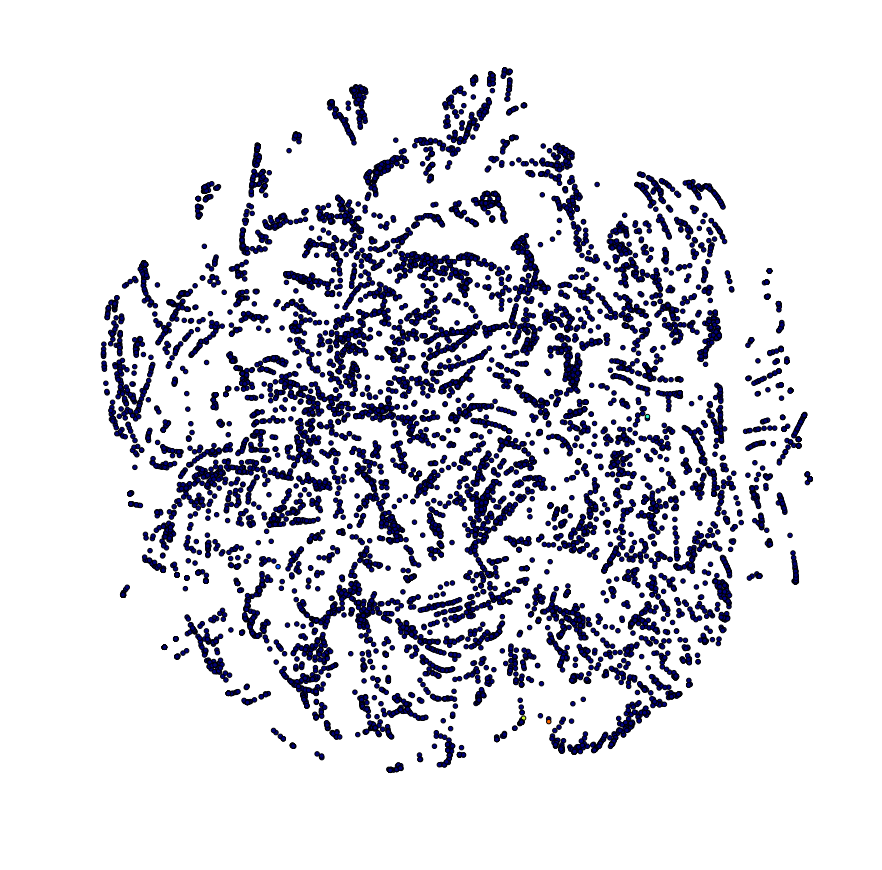

In [29]:
tsne = sm.TSNE(n_components=2, verbose=1, n_iter=1000)
z = tsne.fit_transform(x)

# Color map
cm = pl.get_cmap('jet')
pl.figure(figsize=(15, 15))
pl.scatter(z[:, 0], z[:, 1], c=map(lambda c: cm(1.0 * c / k), y))
pl.axis('off')
pl.show()

Попробуем проанализировать полученные кластеры. Для того, чтобы интерпретировать "суть" каждого из кластеров, построим [radar plot](http://www.wikiwand.com/en/Radar_chart), отображающий их центроиды. Посмотрите на графики и попробуйте объяснить, каким поведением можно охарактеризовать каждый из полученных кластеров? Есть ли среди кластеров похожие?

Реализация радара позаимствована отсюда: 
http://www.science-emergence.com/Matplotlib/MatplotlibGallery/RadarChartMatplotlibRougier/

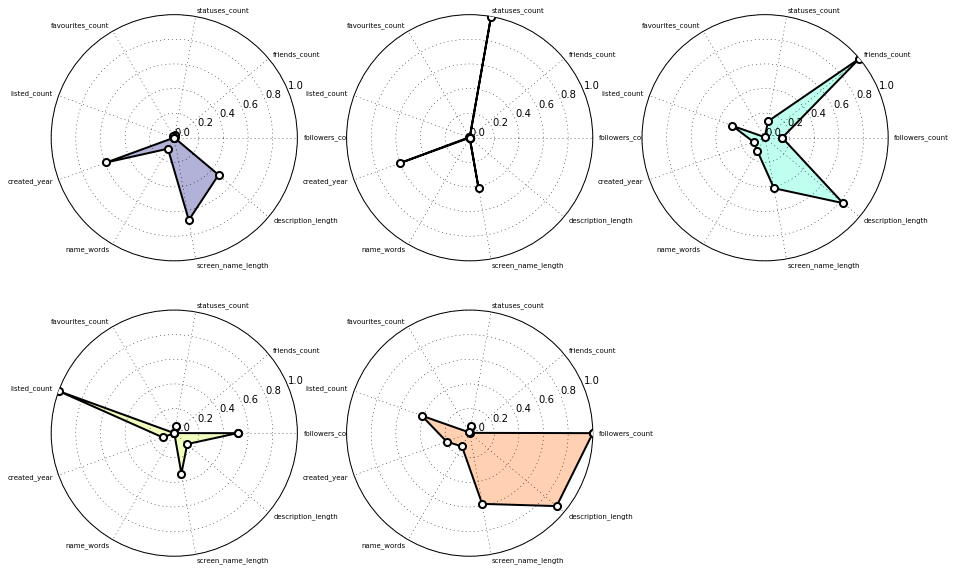

In [30]:
def radar(centroid, features, axes, color):
    # Set ticks to the number of features (in radians)
    t = np.arange(0, 2*np.pi, 2*np.pi/len(features))
    plt.xticks(t, [])

    # Set yticks from 0 to 1
    plt.yticks(np.linspace(0, 1, 6))

    # Draw polygon representing centroid
    points = [(x, y) for x, y in zip(t, centroid)]
    points.append(points[0])
    points = np.array(points)
    codes = [path.Path.MOVETO,] + [path.Path.LINETO,] * (len(centroid) - 1) + [ path.Path.CLOSEPOLY ]
    _path = path.Path(points, codes)
    _patch = patches.PathPatch(_path, fill=True, color=color, linewidth=0, alpha=.3)
    axes.add_patch(_patch)
    _patch = patches.PathPatch(_path, fill=False, linewidth = 2)
    axes.add_patch(_patch)

    # Draw circles at value points
    plt.scatter(points[:,0], points[:,1], linewidth=2, s=50, color='white', edgecolor='black', zorder=10)

    # Set axes limits
    plt.ylim(0, 1)

    # Draw ytick labels to make sure they fit properly
    for i in range(len(features)):
        angle_rad = i/float(len(features))*2*np.pi
        angle_deg = i/float(len(features))*360
        ha = "right"
        if angle_rad < np.pi/2 or angle_rad > 3*np.pi/2: ha = "left"
        plt.text(angle_rad, 1.05, features[i], size=7, horizontalalignment=ha, verticalalignment="center")

# Some additiola imports
import matplotlib
import matplotlib.path as path
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Choose some nice colors
matplotlib.rc('axes', facecolor = 'white')
# Make figure background the same colors as axes 
fig = plt.figure(figsize=(15, 15), facecolor='white')

cm = pl.get_cmap('jet')

clusters = np.unique(y)
for j, cluster in enumerate(clusters):    
    x_c = x[y == cluster]
    centroid = x_c.mean(axis=0)    
    # Use a polar axes
    axes = plt.subplot(3, 3, j + 1, polar=True)
    radar(centroid, data_df.columns.values, axes, cm(1.0 * j / k))

plt.show()

Поздравляем, Вы завершили домашние задания по модулю "Алгоритмы кластеризации". Надеемся, что это было интересно.